<h1>JADE</h1>

In [1]:
from data_loader import DataLoader 
from neural_network import NeuralNetwork
from visualizer import Visualizer
import tensorflow as tf
import numpy as np
import time
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
class JADE:
    def __init__(self, model, data_loader, pop_size=20, generations=5000, p=0.2, c=0.05):
        self.model = model
        self.data_loader = data_loader
        self.pop_size = pop_size
        self.generations = generations
        self.p = p
        self.c = c
        self.dim = model.vector_size
        self.history = {
            'loss': [],
            'accuracy': [],
            'val_loss': [],
            'val_accuracy': [],
            'population_states': []
        }
    
    def train(self):
        start_time = time.time()
        x_train, y_train, x_test, y_test = self.data_loader.get_data()
        
        # Initialize population using He initialization
        population = np.array([self.model.he_vector() for _ in range(self.pop_size)])
        fitness = np.array([self.model.fitness_function(ind, x_train, y_train) for ind in population])
        archive = []
        mu_F, mu_CR = 0.5, 0.5  # Initial means
        
        print(f"Starting JADE optimization for {self.generations} generations...")
        
        for gen in range(self.generations):
            successful_F, successful_CR, deltas = [], [], []
            
            sorted_indices = np.argsort(fitness)
            p_num = max(2, int(self.p * self.pop_size))
            top_indices = sorted_indices[:p_num]
            
            for i in range(self.pop_size):
                # Sample F (mutation factor) from a Cauchy distribution
                F = np.clip(np.random.standard_cauchy() * 0.1 + mu_F, 0, 1)
                while F <= 0:  # Ensure F > 0
                    F = np.clip(np.random.standard_cauchy() * 0.1 + mu_F, 0, 1)
                
                # Sample CR (crossover rate) from a normal distribution
                CR = np.clip(np.random.normal(mu_CR, 0.1), 0, 1)
                
                # Select p-best individual
                pbest = population[np.random.choice(top_indices)]
                
                # Select r1 and r2
                r1 = np.random.choice(np.delete(np.arange(self.pop_size), i))
                
                merged = np.vstack([population, archive]) if len(archive) > 0 else population
                r2_index = np.random.randint(0, len(merged))
                r2 = merged[r2_index]
                
                x_i, x_r1, x_r2 = population[i], population[r1], r2
                
                # Mutation: current-to-pbest
                v = x_i + F * (pbest - x_i) + F * (x_r1 - x_r2)
                
                # Crossover
                cross_mask = np.random.rand(self.dim) < CR
                if not np.any(cross_mask):
                    cross_mask[np.random.randint(self.dim)] = True
                u = np.where(cross_mask, v, x_i)
                
                # Selection
                fit_u = self.model.fitness_function(u, x_train, y_train)
                if fit_u <= fitness[i]:
                    archive.append(population[i].copy())
                    if len(archive) > self.pop_size:
                        archive.pop(np.random.randint(len(archive)))
                    
                    population[i] = u
                    deltas.append(abs(fitness[i] - fit_u))
                    fitness[i] = fit_u
                    successful_F.append(F)
                    successful_CR.append(CR)
            
            # Adapt mu_F and mu_CR using successful values
            if successful_F:
                weights = np.array(deltas) / np.sum(deltas)
                F_array = np.array(successful_F)
                mu_F = (1 - self.c) * mu_F + self.c * np.sum(weights * F_array ** 2) / np.sum(weights * F_array)
            
            if successful_CR:
                mu_CR = (1 - self.c) * mu_CR + self.c * np.mean(successful_CR)
            
            # Log best loss every generation
            best_idx = np.argmin(fitness)
            best_solution = population[best_idx]
            best_loss = fitness[best_idx]
            
            # Update model with best solution and evaluate
            self.model.set_weights_from_vector(best_solution)
            train_loss, train_accuracy = self.model.evaluate(x_train, y_train)
            val_loss, val_accuracy = self.model.evaluate(x_test, y_test)
            
            # Store metrics
            self.history['loss'].append(train_loss)
            self.history['accuracy'].append(train_accuracy)
            self.history['val_loss'].append(val_loss)
            self.history['val_accuracy'].append(val_accuracy)
            
            # Store population state every 500 generations
            if gen % 500 == 0 or gen == self.generations - 1:
                self.history['population_states'].append({
                    'generation': gen,
                    'population': population.copy(),
                    'fitness': fitness.copy()
                })
            
            if gen % 100 == 0 or gen == self.generations - 1:
                print(f"Generation {gen+1}/{self.generations} - Best loss: {best_loss:.4f} - Accuracy: {val_accuracy:.4f}")
        
        # Set final best solution to the model
        best_idx = np.argmin(fitness)
        best_solution = population[best_idx]
        self.model.set_weights_from_vector(best_solution)
        
        execution_time = time.time() - start_time
        
        final_train_loss, final_train_accuracy = self.model.evaluate(x_train, y_train)
        final_val_loss, final_val_accuracy = self.model.evaluate(x_test, y_test)
        
        result = {
            'best_loss': min(self.history['val_loss']),
            'final_loss': final_val_loss,
            'final_accuracy': final_val_accuracy,
            'total_iterations': self.generations,
            'execution_time': execution_time,
            'history': self.history
        }
        
        return result

In [7]:
def run_jade():
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    """Main function to run the JADE algorithm"""
    print("Running Neural Network with JADE optimization...")
    
    # Initialize data loader
    data_loader = DataLoader()
    
    # Initialize neural network
    model = NeuralNetwork(input_dim=784, hidden_dim=32, output_dim=10)
    
    # Initialize JADE optimizer
    jade_optimizer = JADE(model, data_loader, pop_size=20, generations=3000, p=0.2, c=0.05)
    
    # Train the model
    results = jade_optimizer.train()
    
    # Save the model
    model.save_model('jade_model.pkl')
    
    # Visualize results
    visualizer = Visualizer(model, data_loader)
    visualizer.visualize_all(results)
    
    return model, results

Running Neural Network with JADE optimization...
Starting JADE optimization for 3000 generations...
Generation 1/3000 - Best loss: 2.2578 - Accuracy: 0.1627
Generation 101/3000 - Best loss: 1.4272 - Accuracy: 0.5324
Generation 201/3000 - Best loss: 0.9666 - Accuracy: 0.6752
Generation 301/3000 - Best loss: 0.7639 - Accuracy: 0.7443
Generation 401/3000 - Best loss: 0.6515 - Accuracy: 0.7794
Generation 501/3000 - Best loss: 0.5895 - Accuracy: 0.7986
Generation 601/3000 - Best loss: 0.5258 - Accuracy: 0.8140
Generation 701/3000 - Best loss: 0.4865 - Accuracy: 0.8224
Generation 801/3000 - Best loss: 0.4551 - Accuracy: 0.8355
Generation 901/3000 - Best loss: 0.4321 - Accuracy: 0.8405
Generation 1001/3000 - Best loss: 0.4139 - Accuracy: 0.8476
Generation 1101/3000 - Best loss: 0.3951 - Accuracy: 0.8493
Generation 1201/3000 - Best loss: 0.3816 - Accuracy: 0.8532
Generation 1301/3000 - Best loss: 0.3711 - Accuracy: 0.8570
Generation 1401/3000 - Best loss: 0.3633 - Accuracy: 0.8615
Generation 1

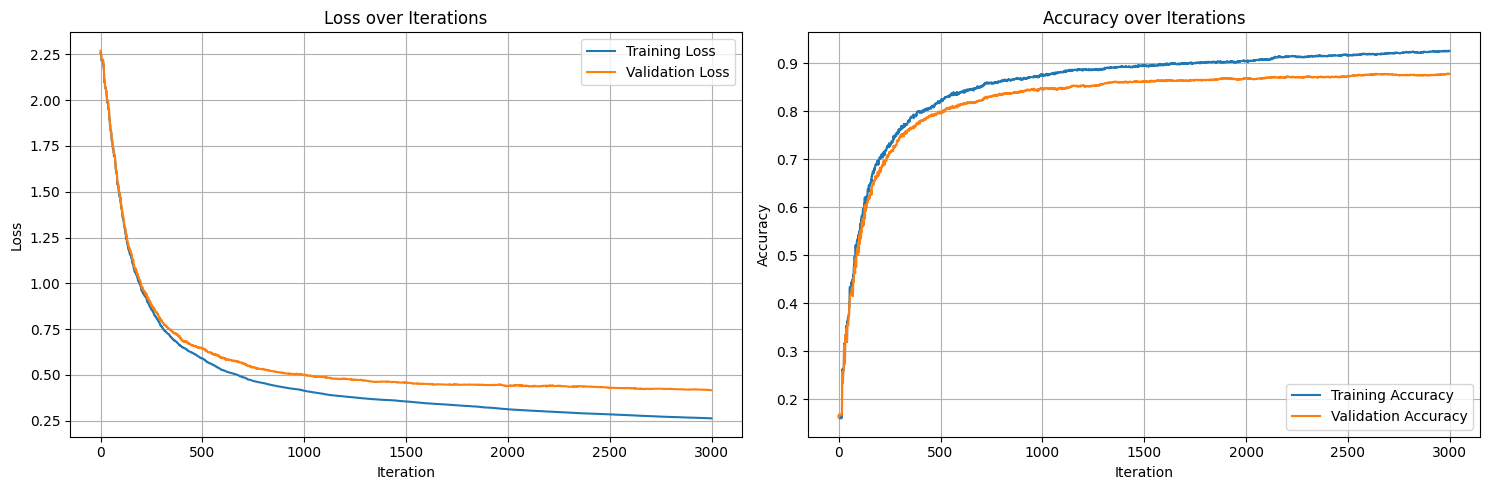

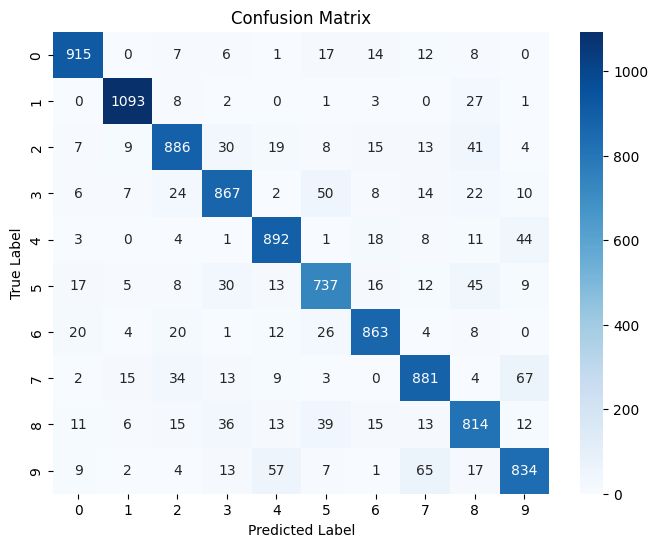

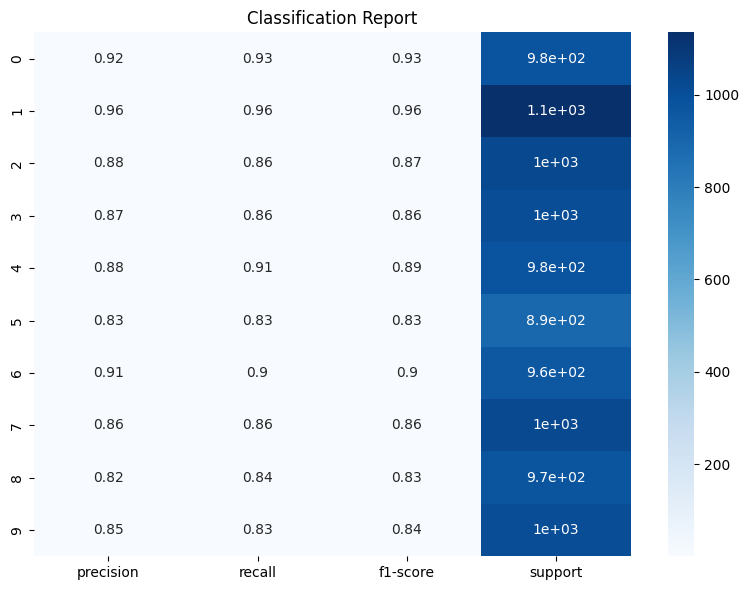

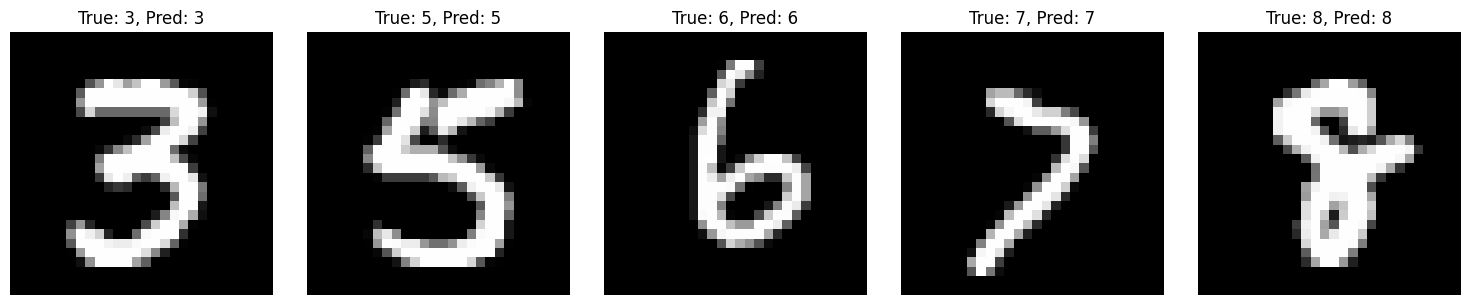

(<__main__.NeuralNetwork at 0x79ef59ce2510>,
 {'best_loss': 0.41655812827487027,
  'final_loss': 0.41655812827487027,
  'final_accuracy': 0.8782,
  'total_iterations': 3000,
  'execution_time': 1157.463830947876,
  'history': {'loss': [2.25780899105063,
    2.25780899105063,
    2.252893533170208,
    2.245665347116062,
    2.2172905459426406,
    2.2172905459426406,
    2.2172905459426406,
    2.2172905459426406,
    2.2172905459426406,
    2.2172905459426406,
    2.2172905459426406,
    2.2172905459426406,
    2.2172905459426406,
    2.197902845251833,
    2.197902845251833,
    2.1781721021732965,
    2.1781721021732965,
    2.1487327913824315,
    2.099430868007435,
    2.099430868007435,
    2.099430868007435,
    2.099430868007435,
    2.068711576065899,
    2.066769557649044,
    2.066769557649044,
    2.066769557649044,
    2.060633756257556,
    2.054579077874432,
    2.049363464572384,
    2.043644972412288,
    2.0205998032879746,
    2.019327264401613,
    1.987039649962947

In [143]:
run_jade()